# Code for Chart Generation

## Imports

In [1]:
import scanpy as sc
import os
import numpy as np
import pandas as pd
import seaborn as sns
import pyviper
import warnings
import matplotlib

## These lines are to fix saving PDF with text recognizible by Adobe Illustrator
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
warnings.filterwarnings("ignore", category=UserWarning, module="scanpy")
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

my_random_seed = 666
n_cells_to_subsample = 3e3
n_cores = 1

sc.settings.n_jobs = int(n_cores)
sc.settings.set_figure_params(dpi=80,vector_friendly=False)

In [2]:
# Load in data
base = "/shares/vasciaveo_lab/data/nepc_organoid_project/new_data"
vp_data_path = os.path.join(base, "pyviper_h5ad_outputs/prot_act_concatenated.h5ad")
vp_data = sc.read_h5ad(vp_data_path)




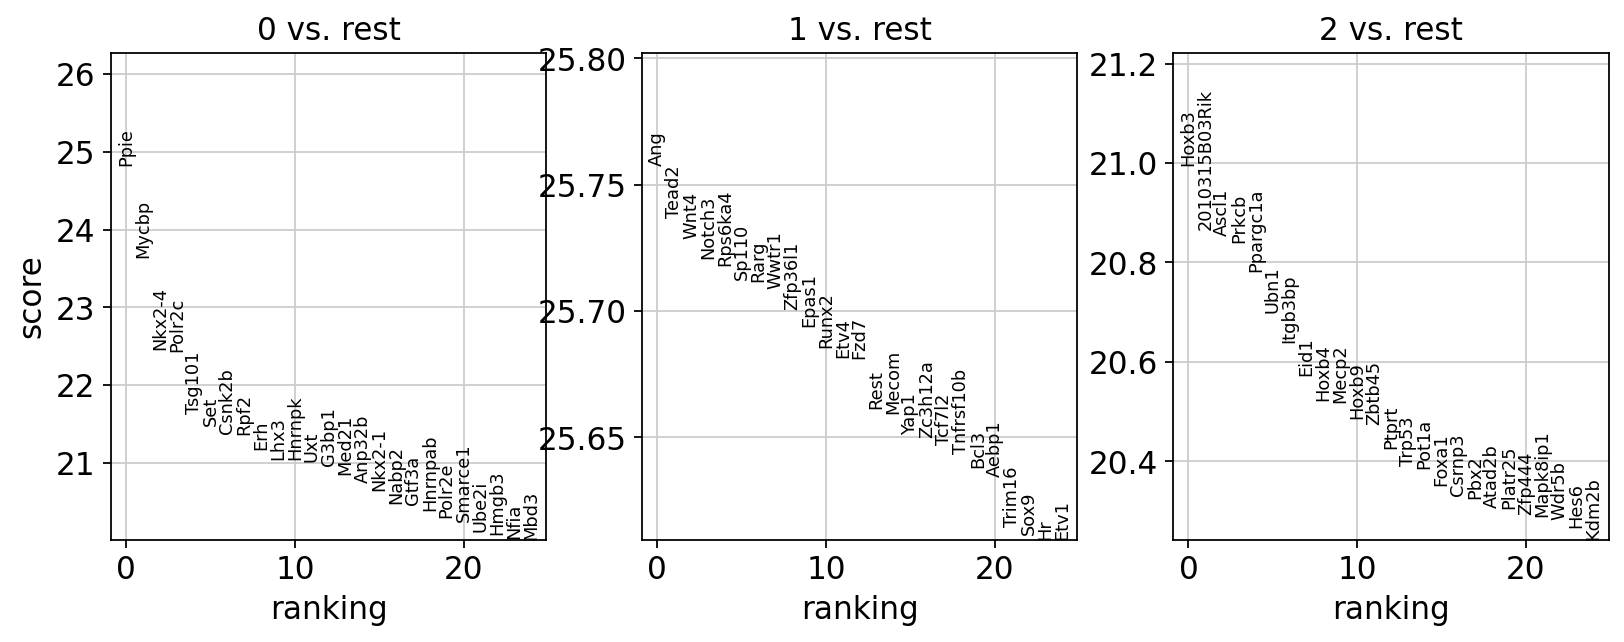

In [3]:
# Get subsampled data for analysis
vp_data_sub = sc.pp.sample(vp_data, n=1000 , rng=my_random_seed , copy=True) # it returns the subsampled adata
sc.tl.rank_genes_groups(vp_data_sub,
                        layer='mLog10' , 
                        groupby='leiden_pas' , method="wilcoxon" , corr_method="bonferroni")
sc.pl.rank_genes_groups(vp_data_sub, n_genes=25, sharey=False )

In [4]:
pd.DataFrame(vp_data_sub.uns['rank_genes_groups']['names']).head(10)
result = vp_data_sub.uns['rank_genes_groups']
groups = result['names'].dtype.names

top_markers_proteins_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})

print("Injecting Wilcoxon over 1000 cells into main data object vp_data")
vp_data.uns['rank_genes_groups'] = vp_data_sub.uns['rank_genes_groups']

Injecting Wilcoxon over 1000 cells into main data object vp_data


In [5]:
cluster_markers = {
    '1': {'Ar','Yap1','Wwtr1','Vim','Runx2'},        
    '2': {'Ppie','Set','Ptma','Atf4'},
    '3': {'Ascl1','Insm1','Chga','Nsd2','Hoxb3','Hoxb4'},
}
marker_matches = sc.tl.marker_gene_overlap(vp_data, cluster_markers)
marker_matches

0    1    2
1  0.0  3.0  0.0
2  4.0  0.0  0.0
3  0.0  0.0  4.0

In [6]:
vp_data.rename_categories('leiden_pas', marker_matches.idxmax())

/home/gaizenman/anaconda3/envs/my_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1093: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.uns[k1][k2].dtype.names = categories


In [7]:
print("Running PAGA ...")
sc.tl.paga(vp_data,groups="leiden_pas")
sc.pl.paga(vp_data, plot=False,random_state=my_random_seed)

print("Running UMAP Analysis initialized with PAGA ...")
sc.tl.umap(vp_data, n_components=3 , random_state=my_random_seed, init_pos='paga')

Running PAGA ...
Running UMAP Analysis initialized with PAGA ...


In [8]:
print("Re-Running KNN for DiffMap ...")
sc.pp.neighbors(vp_data, n_neighbors=15, n_pcs=10, 
                use_rep="X_pca_harmony", 
                key_added="knn_for_diffmap",
                random_state=my_random_seed)

print("Running Diffusion Map Analysis ...")
sc.tl.diffmap(vp_data, 
              neighbors_key = "knn_for_diffmap",
              random_state=my_random_seed)

# Bug Fix for Diffmap
vp_data.obsm["X_diffmap_"] = vp_data.obsm["X_diffmap"][:, 1:] 
vp_data.obsm["X_diffmap"] = vp_data.obsm["X_diffmap_"]

Re-Running KNN for DiffMap ...
Running Diffusion Map Analysis ...


In [9]:
vp_data.obs['leiden_pas'] = vp_data.obs['leiden_pas'].cat.reorder_categories(['1', '2', '3'], ordered=True) 

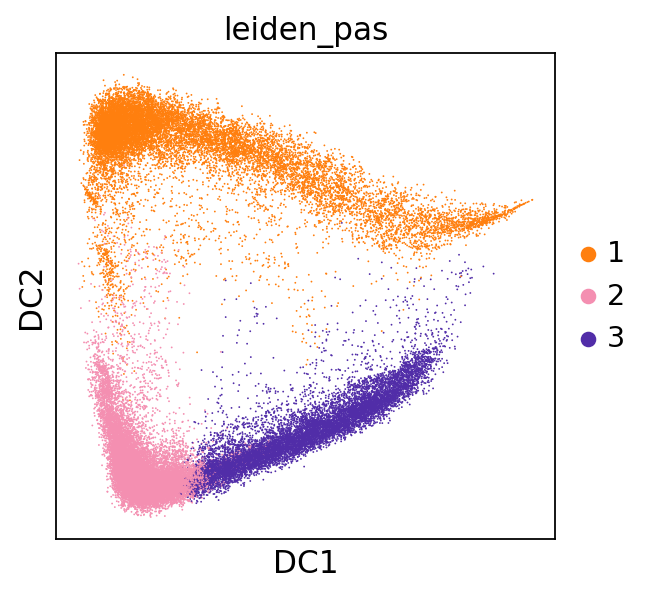

In [10]:
paper_color_palette = ["#FF7F0E","#F48FB1","#512DA8"]
sns.set_palette(paper_color_palette)
sc.pl.diffmap(vp_data, color=["leiden_pas"], palette=paper_color_palette)

## Cytotrace Scores

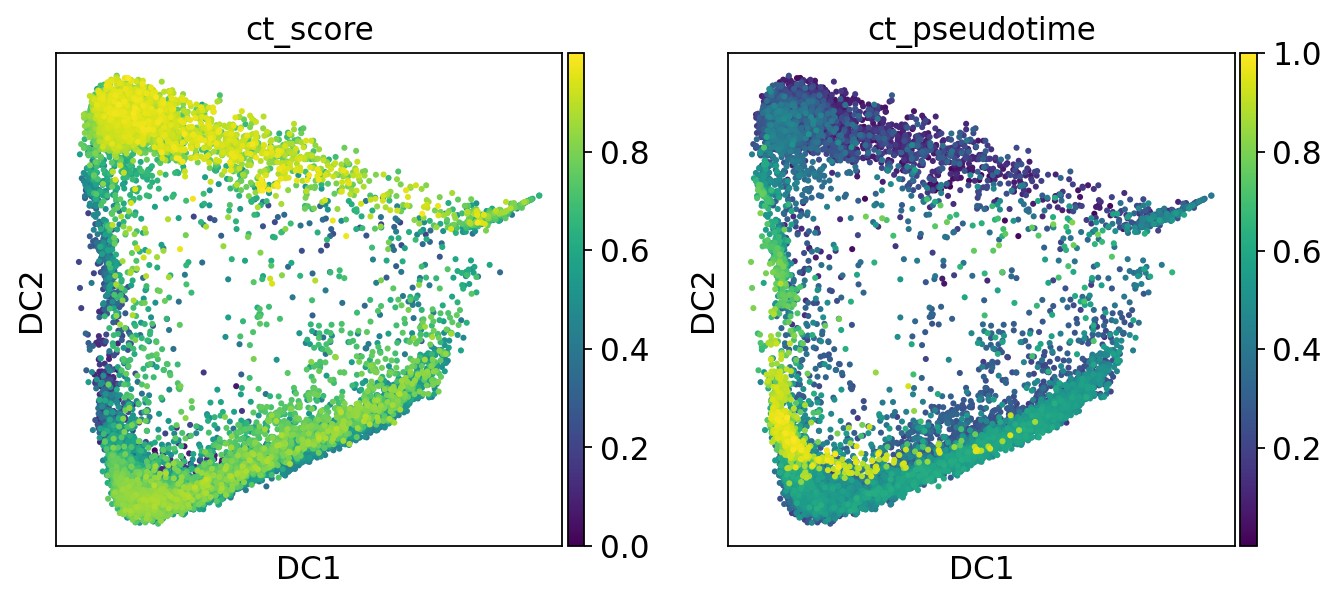

In [11]:
batch = ["NPPO-2","NPPO-4","NPPO-1","NPPO-6","NPPO-5"]
cells_to_keep = [True if x in batch else False for x in vp_data.obs.sample_id_for_paper]
vp_data_sub = vp_data[cells_to_keep]
sc.pl.diffmap(vp_data_sub, color=["ct_score","ct_pseudotime"] , cmap = "viridis" , palette=sc.pl.palettes.default_20 , show=True , return_fig=False , sort_order = True, size = 30 ,
             save='-'+'-'.join(map(str,batch)) + "-samples-diffmap-cytotrace.pdf" )

## Diffmap

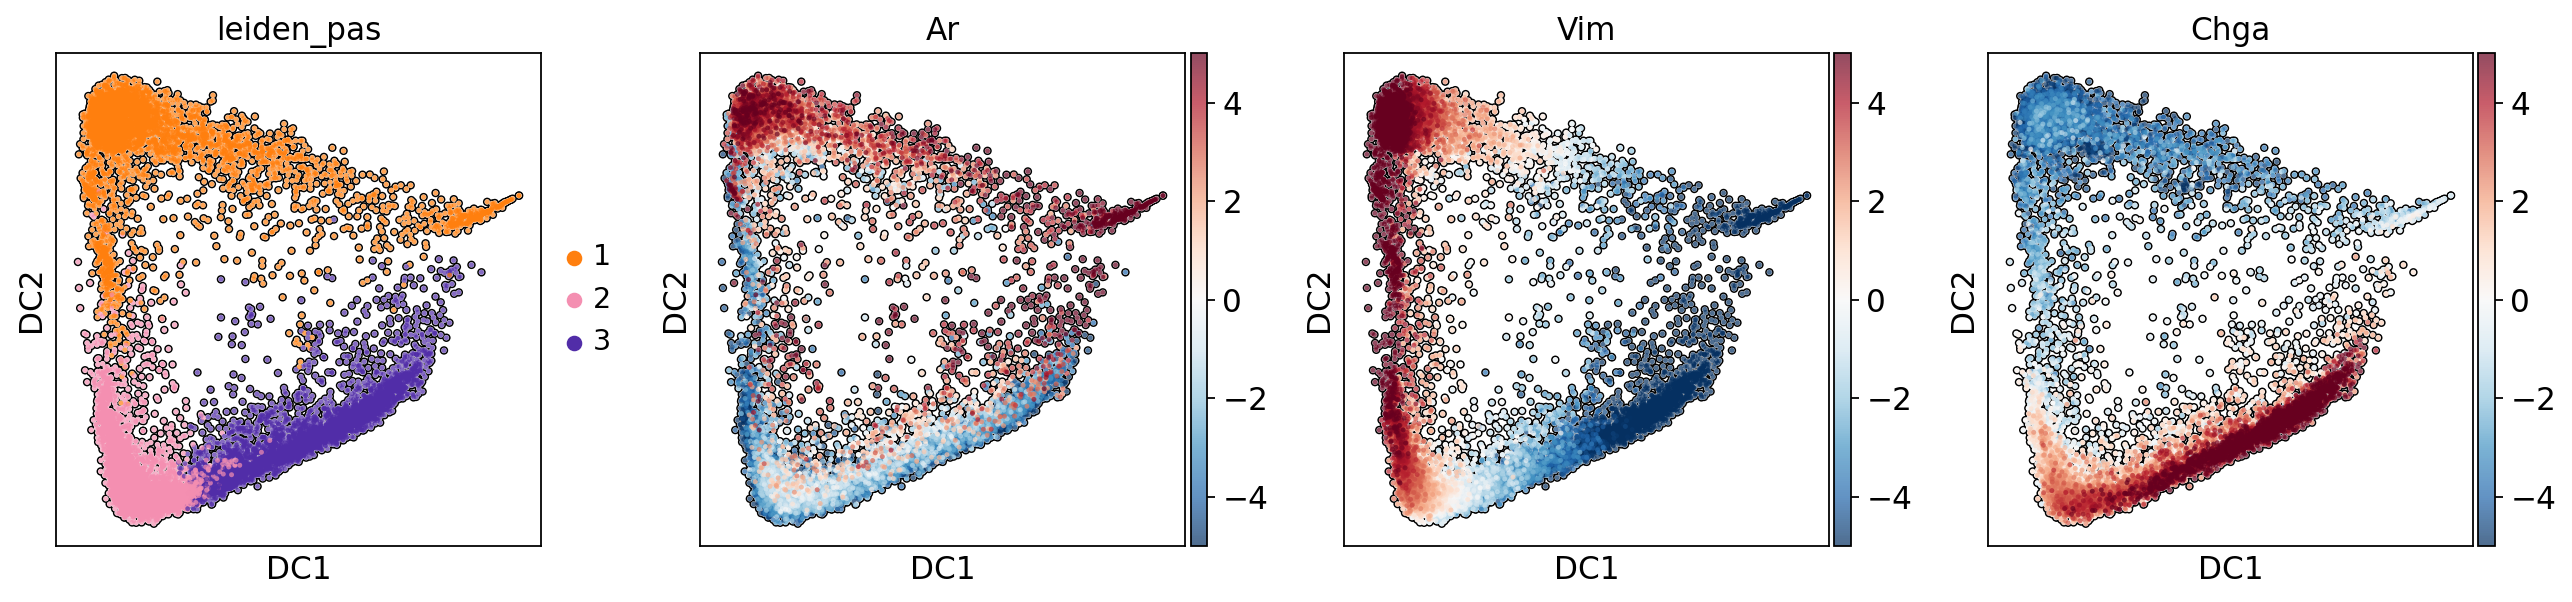

In [12]:
sc.settings.set_figure_params(dpi=80,vector_friendly=False)
features = ["leiden_pas","Ar","Vim","Chga"] 
batch = ['MJ002','MJ004','MJ005','MJ007','MJ008']
cells_to_keep = [True if x in batch else False for x in vp_data.obs.sample_id]
vp_data_sub = vp_data[cells_to_keep]
sc.pl.diffmap(vp_data_sub, color=features , palette=paper_color_palette , cmap = "RdBu_r" , vmin = -5 , vmax = 5 , size = 20 , sort_order=True, add_outline=True , show=True , return_fig=False , save='-'.join(map(str,features)) + "-samples-diffmap.pdf" )
sc.settings.set_figure_params(dpi=80,vector_friendly=True)

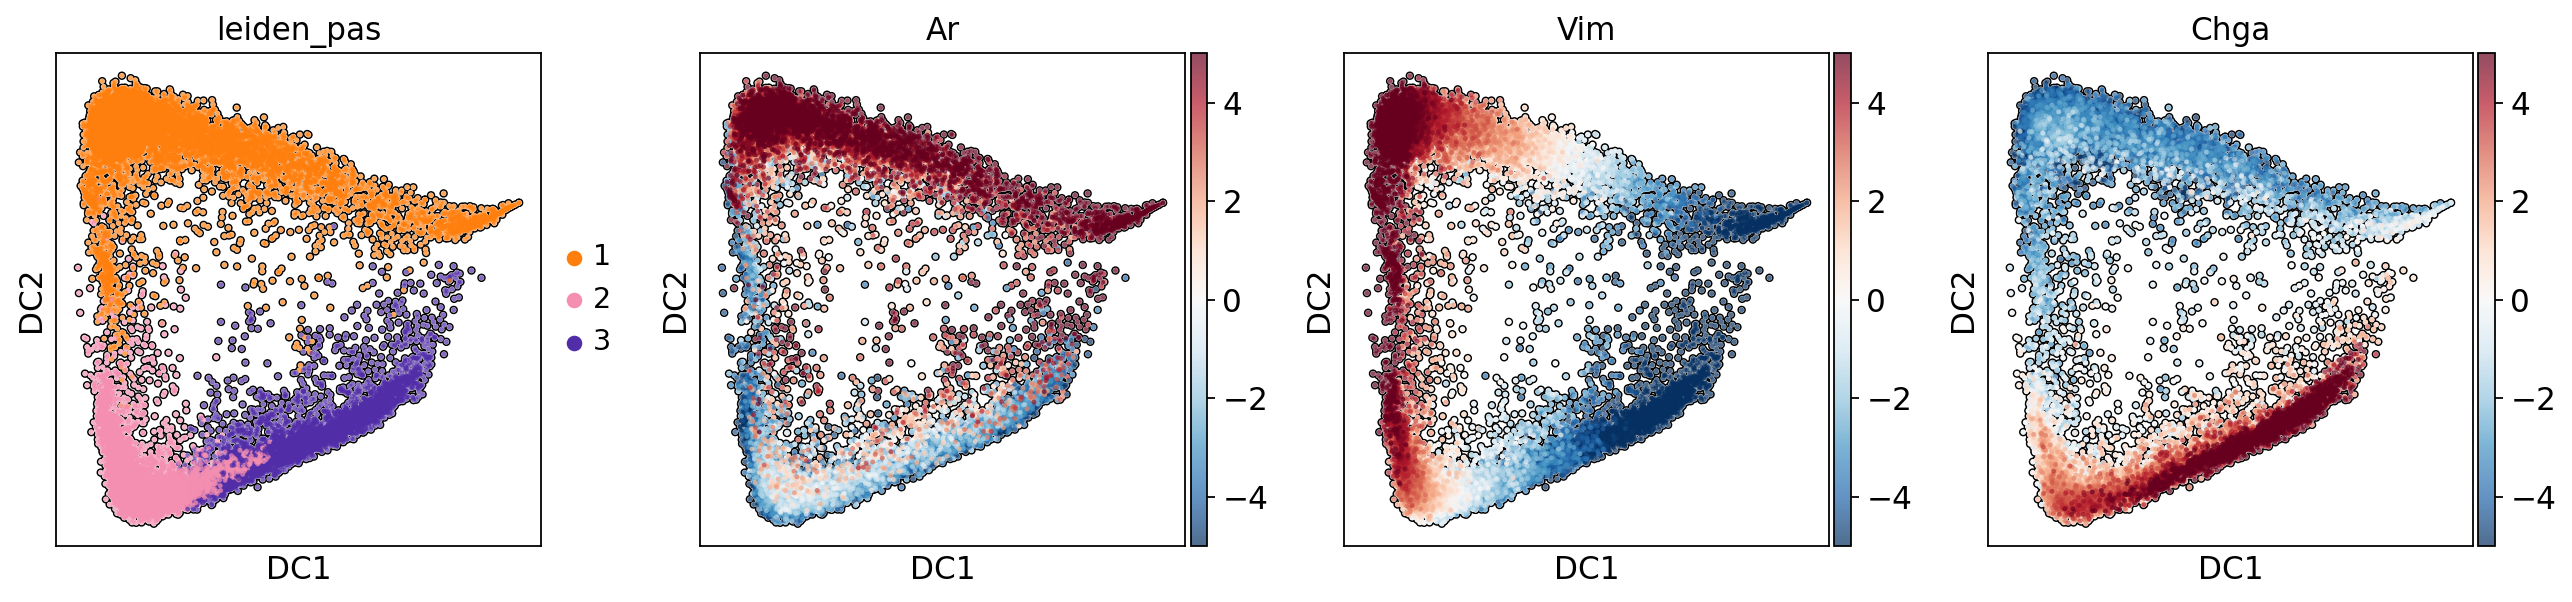

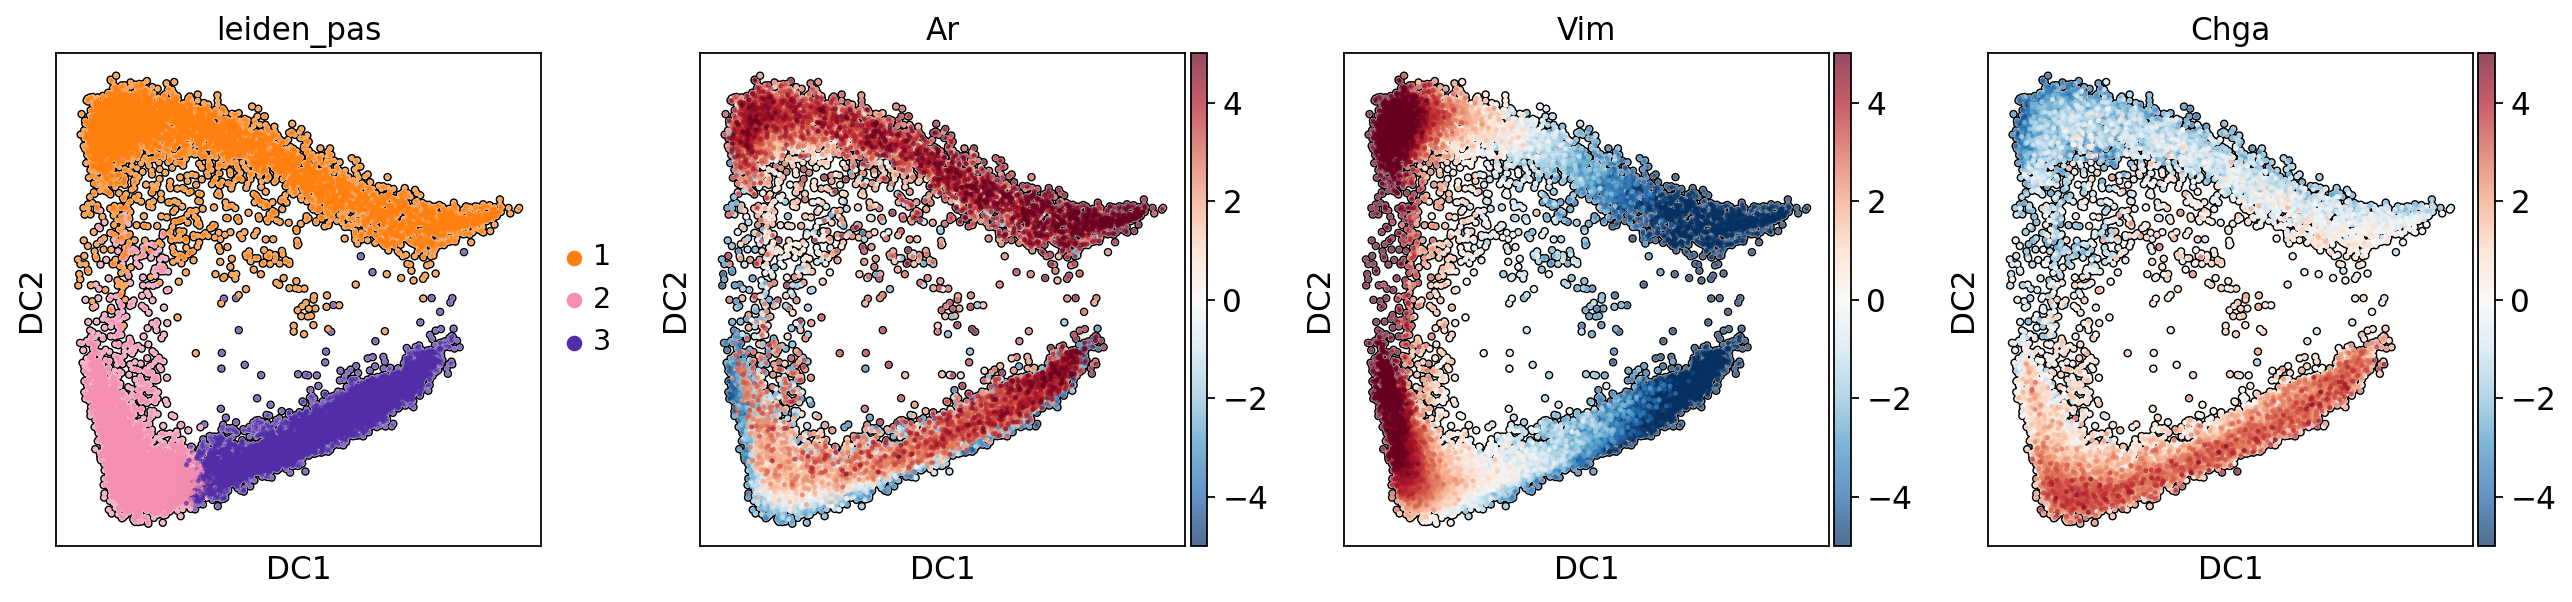

In [13]:
sc.settings.set_figure_params(dpi=80,vector_friendly=False)
features = ["leiden_pas","Ar","Vim","Chga"] 
for batch in ['scRNASeq','snRNASeq']:
    cells_to_keep = [True if x in batch else False for x in vp_data.obs.technology]
    vp_data_sub = vp_data[cells_to_keep]
    sc.pl.diffmap(vp_data_sub, color=features , palette=paper_color_palette , cmap = "RdBu_r" , vmin = -5 , vmax = 5 , size = 20 , sort_order=True, add_outline=True , show=True , return_fig=False , save='-'.join(map(str,features)) + "-samples-diffmap-only-" + batch + ".pdf" )
    # sc.settings.set_figure_params(dpi=80,vector_friendly=True)

In [14]:
vp_cancer_hallmarks_path = os.path.join(base, "pyviper_h5ad_outputs/human_prot_act.h5ad")
vp_cancer_hallmarks = sc.read_h5ad(vp_cancer_hallmarks_path)
vp_cancer_hallmarks

AnnData object with n_obs × n_vars = 45000 × 50
    obs: 'sample', 'sample_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'doublet_score', 'predicted_doublet', 'doublet_info', 'technology', 'ct_score', 'ct_pseudotime', 'ct_num_exp_genes', 'RFP', 'RFP_int', 'sample_pas', 'sample_id_pas', 'n_genes_by_counts_pas', 'total_counts_pas', 'total_counts_mt_pas', 'pct_counts_mt_pas', 'n_genes_pas', 'n_counts_pas', 'doublet_score_pas', 'predicted_doublet_pas', 'doublet_info_pas', 'technology_pas', 'ct_score_pas', 'ct_pseudotime_pas', 'ct_num_exp_genes_pas', 'No.', 'sample_id_for_paper', 'Passage No.', 'categry', 'Note', 'leiden_pas'
    uns: 'gex_data'
    layers: 'mLog10'

In [20]:
vp_cancer_hallmarks.obsm['X_diffmap'] = vp_data.obsm['X_diffmap']
vp_cancer_hallmarks.obs['leiden_pas'] = vp_data.obs['leiden_pas']

/home/gaizenman/anaconda3/envs/my_env/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/gaizenman/anaconda3/envs/my_env/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/gaizenman/anaconda3/envs/my_env/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


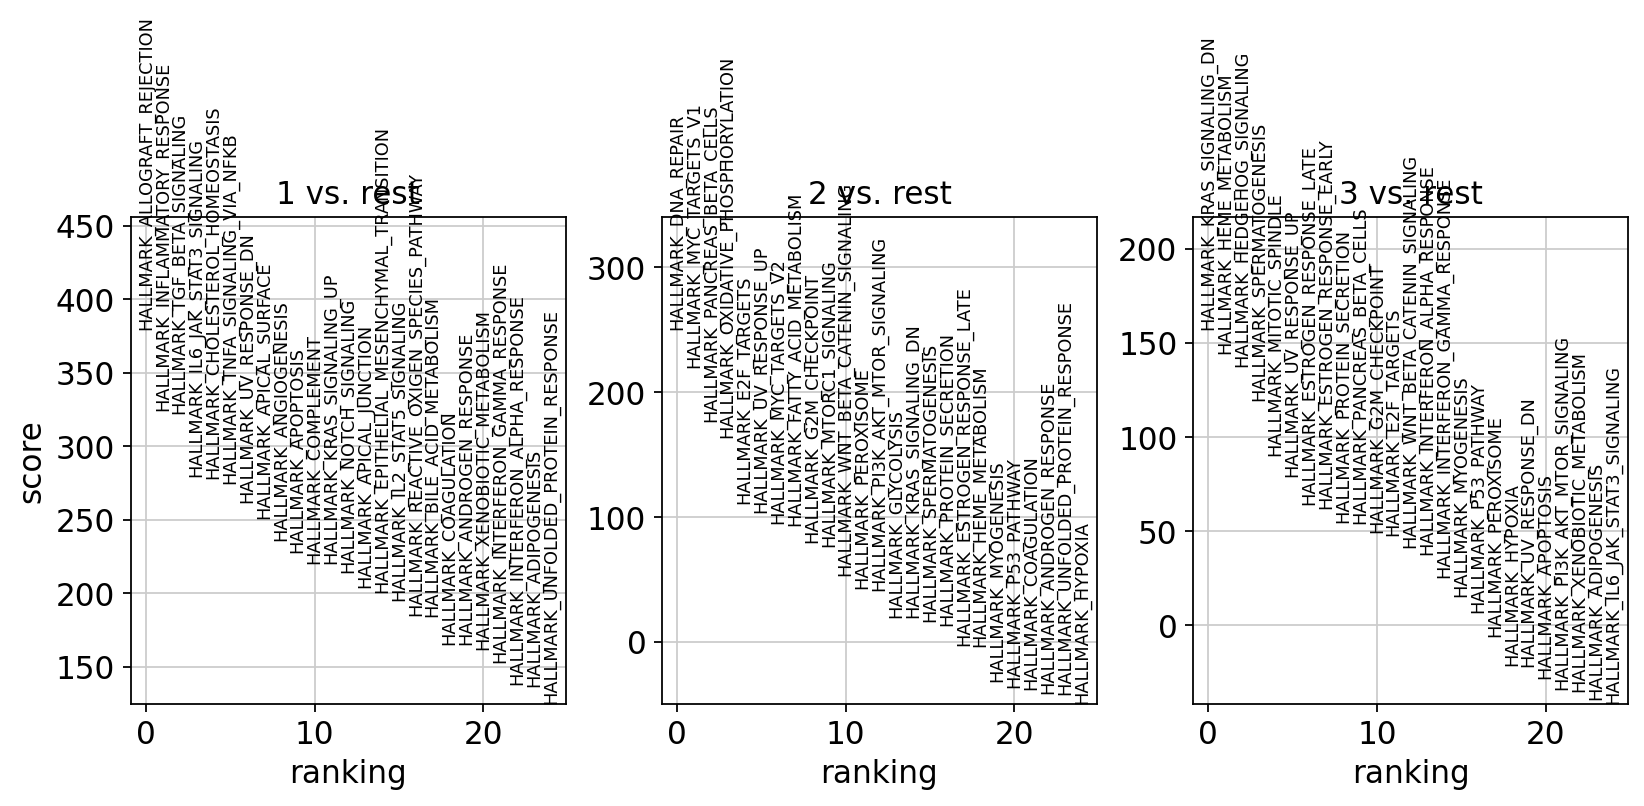

In [21]:
vp_cancer_hallmarks_sub = vp_cancer_hallmarks[vp_cancer_hallmarks.obs.technology == "scRNASeq"]
sc.tl.rank_genes_groups(vp_cancer_hallmarks_sub, 'leiden_pas' , method="t-test")
sc.pl.rank_genes_groups(vp_cancer_hallmarks_sub, n_genes=25, sharey=False )

In [22]:
filename = "-Figure-1K.pdf"

batch = ['MJ002','MJ004','MJ005','MJ007','MJ008']
cells_to_keep = [True if x in batch else False for x in vp_cancer_hallmarks_sub.obs.sample_id]
vp_cancer_hallmarks_sub = vp_cancer_hallmarks_sub[cells_to_keep]

1 MJ002_CGGCTAGCAGCTGCTG-1-MJ002-scRNASeq     True
MJ002_GTTAAGCGTAGCGATG-1-MJ002-scRNASeq    False
MJ002_GAGGTGAGTTTGTGTG-1-MJ002-scRNASeq    False
MJ002_GGGACCTTCGCTTGTC-1-MJ002-scRNASeq    False
MJ002_CAGTAACTCCCTGACT-1-MJ002-scRNASeq    False
                                           ...  
MJ008_AATCGACAGTTGTCGT-1-MJ008-scRNASeq     True
MJ008_TAGTGCACAAGGAGTC-1-MJ008-scRNASeq    False
MJ008_CTTCTCTTCCAAGCCG-1-MJ008-scRNASeq     True
MJ008_CTTCTCTTCGGTCAGC-1-MJ008-scRNASeq     True
MJ008_ACTATTCTCACCCTGT-1-MJ008-scRNASeq     True
Name: leiden_pas, Length: 15000, dtype: bool ['HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', 'HALLMARK_INFLAMMATORY_RESPONSE', 'HALLMARK_NOTCH_SIGNALING', 'HALLMARK_IL6_JAK_STAT3_SIGNALING', 'HALLMARK_TGF_BETA_SIGNALING', 'HALLMARK_ANDROGEN_RESPONSE', 'HALLMARK_DNA_REPAIR', 'HALLMARK_MYC_TARGETS_V1', 'HALLMARK_G2M_CHECKPOINT', 'HALLMARK_E2F_TARGETS']
All markers are valid var_names!
2 MJ002_CGGCTAGCAGCTGCTG-1-MJ002-scRNASeq    False
MJ002_GTTAAGCGTAGCGATG-

/tmp/ipykernel_79981/4247252371.py:53: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  vp_cancer_hallmarks_sub_reordered.uns[f"{cluster_label}_colors"] = [


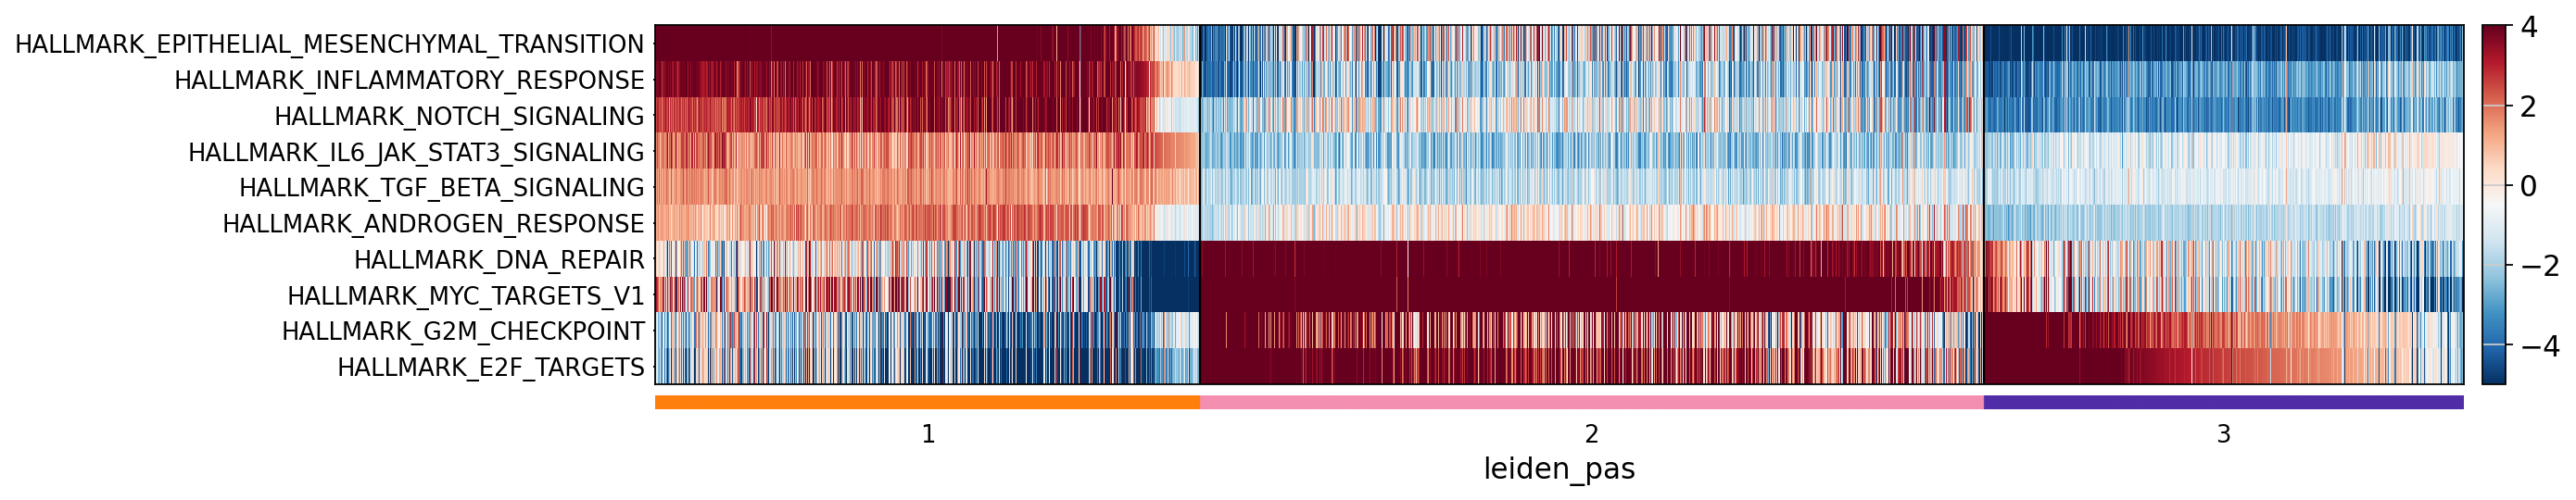

In [23]:
from scipy.cluster.hierarchy import linkage, leaves_list
import numpy as np
import pandas as pd

top_markers = [
    'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION','HALLMARK_INFLAMMATORY_RESPONSE','HALLMARK_NOTCH_SIGNALING' ,'HALLMARK_IL6_JAK_STAT3_SIGNALING' , 'HALLMARK_TGF_BETA_SIGNALING' ,
    'HALLMARK_ANDROGEN_RESPONSE', 'HALLMARK_DNA_REPAIR','HALLMARK_MYC_TARGETS_V1',"HALLMARK_G2M_CHECKPOINT",'HALLMARK_E2F_TARGETS']

top_markers_reordered = top_markers

# -----------------------------------
# Sort cells within each cluster by mean expression of top markers
# -----------------------------------
clustered_indices = []
cluster_label = "leiden_pas"

for cluster in sorted(vp_cancer_hallmarks_sub.obs[cluster_label].unique()):
    # Get indices of cells in this cluster
    cluster_mask = vp_cancer_hallmarks_sub.obs[cluster_label] == cluster
    print(cluster, cluster_mask, top_markers_reordered)
    # all the feature names currently in your AnnData
    all_vars = set(vp_cancer_hallmarks_sub.var_names)

    # which of your markers aren’t present?
    missing = set(top_markers_reordered) - all_vars

    if missing:
        print("These markers are missing from adata.var_names:")
        for gene in sorted(missing):
            print("  ", gene)
    else:
        print("All markers are valid var_names!")
    cluster_data = vp_cancer_hallmarks_sub[cluster_mask, top_markers_reordered]
    
    # Compute mean expression across markers for each cell
    mean_expression = cluster_data.X.max(axis=1)
    
    # Convert to flat array if needed (depending on sparse/dense)
    if not isinstance(mean_expression, np.ndarray):
        mean_expression = mean_expression.A1 if hasattr(mean_expression, 'A1') else np.array(mean_expression).flatten()

    # Get indices of sorted cells within cluster
    sorted_cell_indices = cluster_data.obs_names[np.argsort(-mean_expression)]
    
    clustered_indices.extend(sorted_cell_indices)

# Reorder AnnData object
vp_cancer_hallmarks_sub_reordered = vp_cancer_hallmarks_sub[clustered_indices, :]

# 1. Get your cluster categories
categories = vp_cancer_hallmarks_sub_reordered.obs[cluster_label].cat.categories
# 2. Assign colors by index (make sure the list has enough colors)
vp_cancer_hallmarks_sub_reordered.uns[f"{cluster_label}_colors"] = [
    paper_color_palette[i] for i in range(len(categories))
]

# Plot
sc.pl.heatmap(
    vp_cancer_hallmarks_sub_reordered, top_markers_reordered, 
    groupby=cluster_label, show_gene_labels=True, cmap="RdBu_r", 
    show=True, use_raw=False, log=False, vmin=-5, vmax=4, 
    dendrogram=False, swap_axes=True, figsize=(16, 3.5), save=filename
)
